In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import seaborn as sns
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_profiling

from numpy import mean
from numpy import std

from datetime import datetime
import requests
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

In [ ]:
# fix the constants
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [ ]:
# define a function for the key metric
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

mape_scorer = make_scorer(mape, greater_is_better=False)

In [ ]:
# import data
data_directory = "/work/sf_module_6/data"

In [ ]:
# train = pd.read_csv(data_directory + "/train.csv")
train = pd.read_parquet(data_directory + '/auto.parquet')
test = pd.read_csv(data_directory + "/test.csv")
sample_submission = pd.read_csv(data_directory + "/sample_submission.csv")

# External system requests cache
currency_rates_cache = { 'EUR': {},'USD': {} }

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# Submission
VERSION = 0.1

# Цели и задачи проекта

Проект выполнен командой Crocodiles (участники в алфавитном порядке):

- Волков Михаил - mihails.volkovs@gmail.com
- Елисеева Алина - truelove077@gmail.com 
- Молоткова Софья - molotkova548@gmail.com

Цель проекта:

Создать модель, которая предсказывает стоимость автомобиля по его характеристикам.

Задачи проекта:
- самостоятельно собрать датасет для обучения
- привести спарсенный датасет и тренировочный к единому виду
- выполнить работу в команде
- попробовать различные алгоритмы машинного обучения

Метрика для оценки качества - MAPE  (Mean Percentage Absolute Error) - средняя абсолютная ошибка в процентах.


КРИТЕРИИ ОЦЕНКИ

- Качество кода и оформление проекта на Github (соблюдение стандартов оформления pep-8, комментирование кода, наличие выводов) — 3 балла.
- Качество разведывательного анализа данных (визуализация, очистка данных, работа с выбросами) — 3 балла.
- Работа с признаками (выбор признаков, генерация новых признаков) — 3 балла.
- Обоснованность выбора алгоритма (ансамбля алгоритмов): наличие экспериментов, промежуточных и итоговых выводов — 3 балла.
- Наличие стакинга — 3 балла.
- Качество решения: Результат метрики MAPE — 3 балла.
- Работа в команде — 3 балла.
- Работа сдана к дедлайну — 3 балла. 

Что было сделано:

- С помощью парсера собраны данные по автомобилям с сайта auto.ru. [Ссылка на репозитарий] (https://github.com/volkovs/data-science-colabs).
- Датасет получился достаточно большим, поэтому для удобства работы перевели его в формат parquet.
- Провели предварительный анализ данных для тестовой выборки, которая была нам предоставлена, и обучающей. Сравнили колонки, типы данных, привели к одному виду, соединили в один датасет.
- Обработали выбросы, пропущенные значения, проанализировали взаимосвязь переменных между собой и с целевой переменной.
- Визуализиовали распределение признаков
- Создали новые признаки.
- Провели корреляционный анализ для отбора признаков.
- Построили наивную модель с помощью линейной регрессии.
- Обучили модели - CatBoost, ExtraTreesRegressor
- Провели настройку параметров и выбрали модель с самой высокой метрикой


Что еще можно сделать:

1. Обработать колонку description с помощью WordCloud, word2vec
2. Добавить рейтинг для не только для марок машин, но и для моделей
3. Вытащить новую информацию из complectation_dict, equipment_dict, super_gen.

# Предварительный анализ данных

## Сравнение тестовой и тренировочной выборки

С помощью парсера c сайта auto.ru был получен датасет, который поместили в train. Датасет, который был дан как пример, находится в test. Ниже мы их сравним и посмотрим, какие именно колонки потребуют дополнительной обработки.

In [ ]:
# check gaps, column names and data type in test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [ ]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [ ]:
# check gaps, column names and data type in train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368742 entries, 0 to 368741
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             368742 non-null  object
 1   brand                368742 non-null  object
 2   color                368742 non-null  object
 3   description          354031 non-null  object
 4   engineDisplacement   368740 non-null  object
 5   enginePower          368740 non-null  object
 6   fuelType             368367 non-null  object
 7   hidden               368742 non-null  object
 8   mileage              368742 non-null  int64 
 9   model                368742 non-null  object
 10  name                 368742 non-null  object
 11  numberOfDoors        189098 non-null  object
 12  price                368742 non-null  int64 
 13  productionDate       368742 non-null  object
 14  start_date           368742 non-null  object
 15  url                  368742 non-nu

Большинство колонок с категориальным типом, еще 4 колонки - целочисленные (Владельцы, price, parsing_unixtime, mileage), оставщиеся 2 колонки - вещественные (engineDisplacement, enginePower). Также у нас нет полного соответсвия колонок для test и train. 

In [ ]:
# let's look at the values ​​in the columns
train.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,hidden,mileage,model,...,start_date,url,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
120953,внедорожник,LADA (ВАЗ),красный,"Нива на ходу, Двигатель работает но дымит треб...",1.6,75,Бензин,,73000,2121 (4x4),...,24 мая 2020,https://auto.ru/cars/used/sale/vaz/2121/109828...,механическая,3,,Оригинал,полный,Левый,Не требует ремонта,True
299559,седан,Toyota,белый,Собcтвeнник. Хтc. Вcе работaет иcпрaвнo. Xорoш...,1.6,165,Бензин,,230000,Carina,...,23 декабря 2020,https://auto.ru/cars/used/sale/toyota/carina/1...,механическая,3,,Оригинал,передний,Правый,Не требует ремонта,True
221361,внедорожник,Opel,чёрный,Два комплекта резины на литых дисках.Климат ко...,1.8,140,Бензин,,139000,Mokka,...,17 декабря 2020,https://auto.ru/cars/used/sale/opel/mokka/1101...,автоматическая,1,,Оригинал,полный,Левый,Не требует ремонта,True


Общее описание колонок для обучающей выборки (train):

- bodyType - 23 варианта кузова автомобиля - перекодировать в дамми или onehot?
- brand - 162 различных марки автомобиля - объединить и перекодировать
- color - цвет авто - потребуется перевести в числовой формат
- description - описание продавца - пока уберем из выборки
- engineDisplacement - объем двигателя, число - убрать для окончательного анализа LTR из тестовой выборки
- enginePower - мощность двигателя, число - убрать из тестовой N12
- fuelType - 8 типов топлива - перекодировать
- hidden - пустая колонка - убираем из выборки
- mileage - пробег, число - ок
- model - 1743 вариантов различных моделей автомобилей - перекодировать
- name - объем двигателя и количество лошадиных сил - сделать две отдельных колонки - объем двигателя и количество л.с.
- numberOfDoors - количество дверей - большое количество пропущенных значений
- price - целевая переменная - очень большой разброс от 11 тысяч до 248 623 920 - можно вручную проверить самые крайние значения, чтобы понимать нужны они в выборке или нет. 
- productionDate - год производства - ок
- start_date - дата начала продаж - сменить формат
- url - ссылка на авто - он нужен в конечном итоге?
- vehicleTransmission - 4 варианта коробки передач - перекодировать?
- Владельцы - количество владельцев автомобиля - ок
- Владение - время владения автомобилем - везде 1 - похоже, что неполностью спарсилось значение - дропаем
- ПТС - оригинал или дубликат - в числовой
- Привод - 3 варианта привода - в числовой
- Комплектация - что входит в комплектацию автомобиля - словарь - будем вытаскивать параметры?
- Руль - 2 варианта руля - в числовой
- Состояние - меньше 0.1% требует ремонта, остальные на ходу - убираем колонку
- Таможня - меньше 0.1% было не растаможено - убираем колонку

Переменные смещенные, в некоторых есть большой разброс.

In [ ]:
# create a report using pandas profiling
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/42 [00:00<?, ?it/s]

Колонки, которых не хватает - анализируем, нужно ли глубже уходить в карточку, чтобы вытащить дополнительные данные.

- `car_url` - есть - `url` - попробуем переименовать
- `complectation_dict` - очень много пропущенных значений 81.5% - пример - {"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel"..."]} - пока удаляем
- `equipment_dict` - 
- `image` - ссылка на картинку - удаляем, так как пока не умеем работать с картинками
- `model_info` - {"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}
- `model_name` - `model` - переименовать
- `parsing_unixtime` - дата, когда был запущен парсер - min = 20.10.20, max = 26.10.20  
- `priceCurrency` - rub - одно значение - скорее всего удалим
- `sell_id` - уникальный номер продавца - попробуем обучить этим признаком и без него
- `super_gen` - пример - {"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5} - пока убираем
- `vendor` - EUROPEAN или JAPANESE - попробуем добавить на основании марки машины

In [ ]:
# let's look at the most common value in the columns
for col in test.columns:
   if col != 'complectation_dict':
       print(f'name of column: {col}','\n', test[col].value_counts()[:10], '\n')

name of column: bodyType 
 седан                   13147
внедорожник 5 дв.       12228
лифтбек                  2232
хэтчбек 5 дв.            2124
универсал 5 дв.          1276
минивэн                   995
купе                      824
компактвэн                489
хэтчбек 3 дв.             485
пикап двойная кабина      280
Name: bodyType, dtype: int64 

name of column: brand 
 BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
Name: brand, dtype: int64 

name of column: car_url 
 https://auto.ru/cars/used/sale/lexus/nx/1101286503-d92b6ad5/                 1
https://auto.ru/cars/used/sale/nissan/almera_classic/1101165367-302b8b33/    1
https://auto.ru/cars/used/sale/volkswagen/touareg/1101366877-2a43507a/       1
https://auto.ru/cars/used/sale/bmw/x6/1098756512-a402d96f/                   1
https://auto.ru/cars/used/sale/bmw/x5/1100507446-a2bbeaf9/

Дополнительную обработку потребуют признаки - description, engineDisplacement, enginePower, equipment_dict, name, super_gen, vehicleConfiguration, Владельцы, Владение.

## Приведение тестовых и тренировочных данных к единому формату

In [ ]:
# Spider launch time
train['parsing_unixtime'] = 1611599960

# Assumption to be checked at histogram
train['priceCurrency'] = 'RUB'

# Define field present in Test data set and used for submission
train['sell_id'] = 'n/a'

# Define field to be mapped / populated in Test data set (from 'brand')
train['vendor'] = 'to be mapped'

# Artificial fields for merging data sets
test['price'] = -1

# Common columns found
common_columns = list(set(train.columns) & set(test.columns))
common_columns.sort()
print('Common columns:', common_columns)
print('Common columns count:', len(common_columns))



Common columns: ['bodyType', 'brand', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'name', 'numberOfDoors', 'parsing_unixtime', 'price', 'priceCurrency', 'productionDate', 'sell_id', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
Common columns count: 24


In [ ]:
# Merging data sets into one to be EDA-ed
train['data_type'] = 'train'
test['data_type'] = 'test'
common_columns.append('data_type')
df = train[common_columns]
df = df.append(test[common_columns])
print('Train size:', len(train))
print('Test size:', len(test))
print('Data set size:', len(df))

# forbid direct usage?
# train = None
# test = None

Train size: 368742
Test size: 34686
Data set size: 403428


## Базовая предобработка
- Изменение типов данных (str -> int/float)
- Очистка от шумов


In [ ]:
def basic_preprocess(df):

    # Remove artifacts like ' 5 дв.' in values like 'внедорожник 5 дв.'
    regex = re.compile(r"\s\d\sдв\.\s*", re.IGNORECASE)
    df['bodyType'] = df['bodyType'].apply(lambda x: re.sub(regex, '', x))

    # Remove units and converting to number (values like '2.0 LTR')
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: x if (type(x) == float or x is None) else None if (x == ' LTR') else float(x.replace(' LTR', '').strip()))

    # Remove units and converting to number (values like '249 N12')
    df['enginePower'] = df['enginePower'].apply(lambda x: x if (type(x) == int or x is None) else None if (x == ' N12') else int(x.replace(' N12', '').strip()))

    # Remove non-numbers (in values like '3 или более')
    regex = re.compile(r"\D+")
    df['Владельцы'] = df['Владельцы'].apply(lambda x: int(re.sub(regex, '', x)))

    # Convert data type
    df['productionDate'] = df['productionDate'].astype('int')


In [ ]:
basic_preprocess(df)

# EDA
- Обработка пропусков и выбросов
- Исследование распределений признаков

In [ ]:
print('Proportion of nan per column')
print(df.isnull().sum() / df.shape[0])

Proportion of nan per column
bodyType               0.000000
brand                  0.000000
color                  0.000000
description            0.036465
engineDisplacement     0.000005
enginePower            0.000005
fuelType               0.000930
mileage                0.000000
name                   0.000000
numberOfDoors          0.445294
parsing_unixtime       0.000000
price                  0.000000
priceCurrency          0.000000
productionDate         0.000000
sell_id                0.000000
vehicleTransmission    0.000005
vendor                 0.000000
Владельцы              0.000000
Владение               0.056245
ПТС                    0.000072
Привод                 0.000005
Руль                   0.000000
Состояние              0.000000
Таможня                0.000000
data_type              0.000000
data_type              0.000000
dtype: float64


In [ ]:
def outliers_detection_IQR(data, col):

    # print min, max values, outlier boundaries, and proportion of outliers
    # return oulier boundaries

    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print(col+' feature')
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(len(data[(~data[col].between(left, right))&(~data[col].isna())])/len(data)))
        print('\n')
    
    return left, right

Сначала разберём признаки, содержащие пропуски. Признак `description` содежит текст и будет обработан позже.

`engineDisplacement` & `enginePower`

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


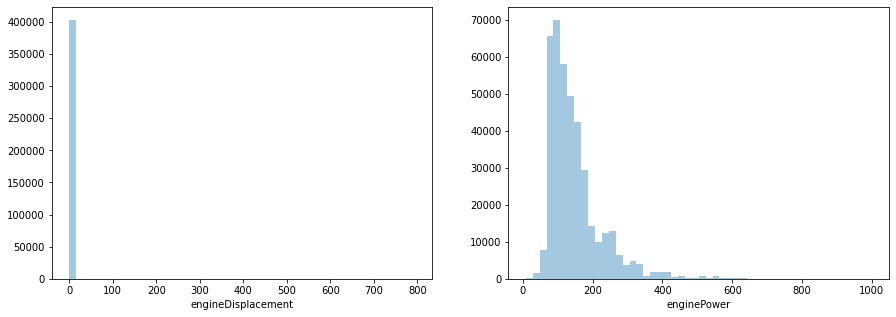

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(['engineDisplacement', 'enginePower']):
    sns.distplot(df[col], kde=False, ax=axes.flat[i])

In [ ]:
outliers_detection_IQR(df, 'engineDisplacement')
outliers_detection_IQR(df, 'enginePower');

engineDisplacement feature
min: 0.2, max: 795.0
outlier boundaries: [0.40000000000000036, 3.5999999999999996]
ratio of outliers: 0.05983471647976839


enginePower feature
min: 8.0, max: 1000.0
outlier boundaries: [-10.0, 278.0]
ratio of outliers: 0.06299265296409769




1. Распеределения смещены, пропущенные значения лучше заменить медианой.
2. По методу межквартильного размаха в каждом признаке около 6% наблюдений являются выбросами (экстремально большие значения).




`engineDisplacement` - объём двигателя, для легковых автомобилей варьируется от меньше 1 л до 6; 8 л - максимальный объём двигателя мощного суперкара. Все значения выше 6 л (это меньше 1% выборки) заменим средним по наблюдениям с объёмом двигателя до 6 л.

`enginePower` - мощность двигателя. Мощность среднего автомобиля - 130-200 л.с., мощность новейших джипов может достигать 600 л.с. Максимальная мощность автомобиля из тестовой выборки - 630 л.с. Тренировочный сет содержит семплы с мощностью больше 700 л.с. Попробуем в качестве границы выбросов по мощности установить 600 л.с.; выбросы заменим средним.

`fuelType`, `numberOfDoors`, `vehicleTransmission`, `ПТС` & `Привод`

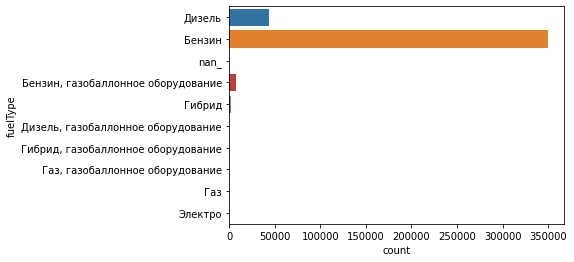

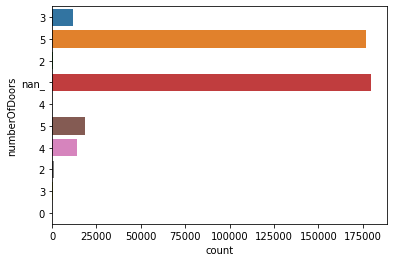

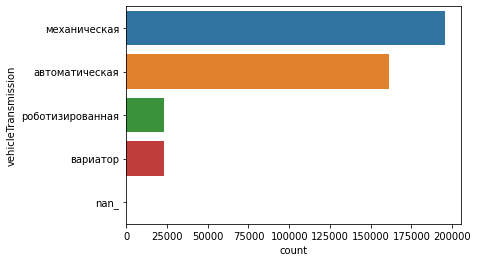

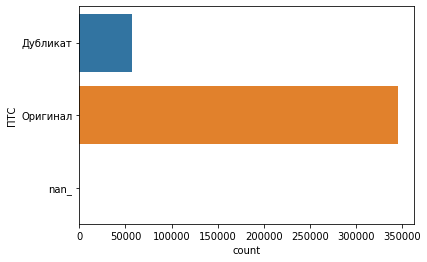

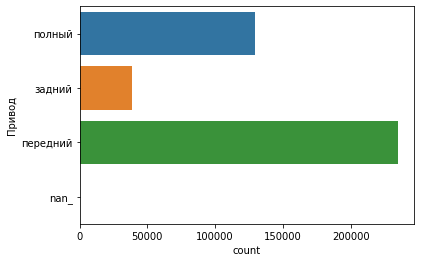

In [ ]:
for col in ['fuelType', 'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод']:
    sns.countplot(y=df.fillna('nan_')[col])
    plt.show()

1. `fuelType` и `numberOfDoors` содежат перемешанные классы. Почистим на этапе обработки.
2. Все признаки выше несбалансированы, имеется сильный перевес в сторону одного-двух классов.
3. Существенное количество пропусков есть только в `numberOfDoors`, выделим их в отдельный класс. В остальных признаках заменим пропуски на самое популярное значение.

In [ ]:
# create a new column, in which we will combine the variator, robotic and automatic transmission
df['vehicleTransmission_two'] = df['vehicleTransmission'].replace(['вариатор', 'роботизированная'], 'автоматическая')

`bodyType`, `color`, `Владельцы` & `Руль`

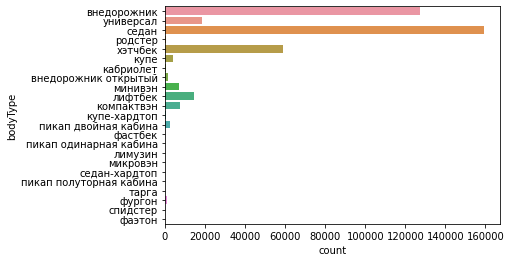

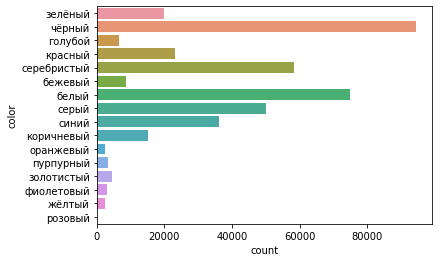

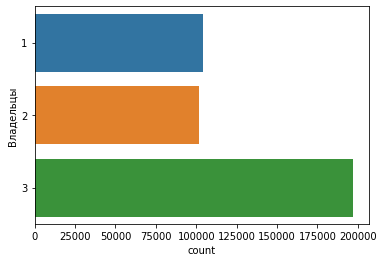

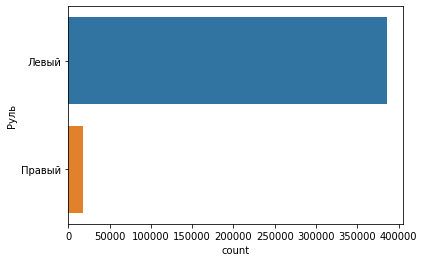

In [ ]:
for col in ['bodyType', 'color', 'Владельцы', 'Руль']:
    sns.countplot(y=df[col])
    plt.show()

1. В `bodyType` и `color` много классов, большинство из которых содержат очень мало примеров. На этапе обработки выделим несколько самых популярных классов, остальные объединим.
2. `Руль` - бинарный признак с сильным перевесом в одну сторону, вероятно окажется бессмысленным.

In [ ]:
# we take the ten most popular body options
bodyType = df.bodyType.value_counts().head(10)
# everything that does not fall into the bodyType is moved to the category 'other'
df['bodyType_other'] = df.bodyType
df['bodyType_other'] = df['bodyType_other'].apply(lambda x: x if x in bodyType else 'другой')

In [ ]:
# check
df.bodyType_other.value_counts()

седан                   159170
внедорожник             127173
хэтчбек                  58873
универсал                18516
лифтбек                  14547
компактвэн                7287
минивэн                   6842
купе                      3933
другой                    3012
пикап двойная кабина      2522
внедорожник открытый      1553
Name: bodyType_other, dtype: int64

In [ ]:
# by analogy we do for the color column
# combine golden, purple, violet, orange, yellow and pink
color = df.color.value_counts().head(10)
df['color_other'] = df.color
df['color_other'] = df['color_other'].apply(lambda x: x if x in color else 'другой')

`brand`

<AxesSubplot:xlabel='count', ylabel='brand'>

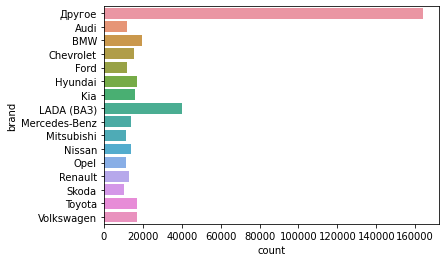

In [ ]:
top_brands = df.brand.value_counts()[:15].index.tolist()
def reduce_brand(x):
    if x in top_brands:
        return x
    
    else:
        return 'Другое'

sns.countplot(y=df['brand'].apply(reduce_brand))

`brand` - категориальный признак, содежит порядка 170 уникальных значений. На гистограмме отображены классы с количеством семплов больше 10K. Остальные классы объединены в 'Другое'. 

Для обучения с помощью СatBoost попробуем оставить все варианты, где количество значений более 1К - будет список из 53 марок и 'Другое'. Для других алгоритмов оставим 15 самых популярных марок, остальные - объединим.

`mileage` & `productionDate`

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


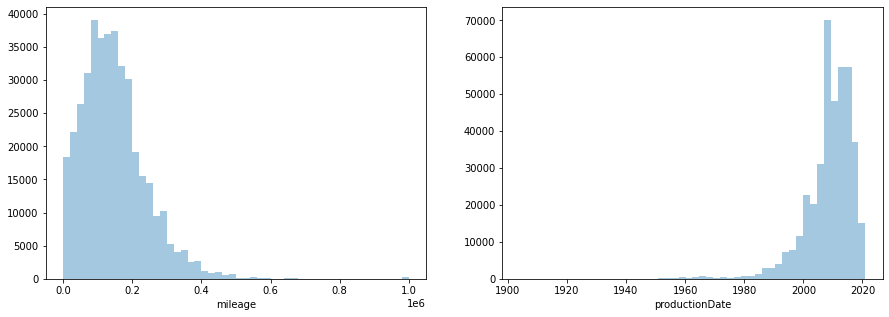

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(['mileage', 'productionDate']):
    sns.distplot(df[col], kde=False, ax=axes.flat[i])

In [ ]:
outliers_detection_IQR(df, 'mileage')
outliers_detection_IQR(df, 'productionDate');

mileage feature
min: 1, max: 1000000
outlier boundaries: [-94908.5, 376943.5]
ratio of outliers: 0.022618658100082296


productionDate feature
min: 1904, max: 2021
outlier boundaries: [1994.0, 2026.0]
ratio of outliers: 0.049272732680924476




Распределения смещены, содержат не более 5% выбросов по методу межквартильного размаха. Попробуем срезать выбросы по более лояльным границам. Например, `mileage` меньше 600K км имеет больше 99.8% выборки, а `productionDate` старше 1960 года у 99.7%. Изучим более детально оба признака.


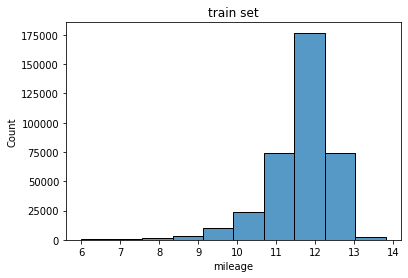

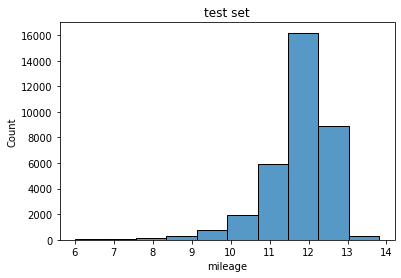

In [ ]:
for kind in ['train', 'test']:
    sns.histplot(df[(df.data_type==kind)&(df.mileage>400)]['mileage'].apply(np.log), bins=10)
    plt.title(f'{kind} set')
    plt.show()

Распределения `mileage`  в тренировочной и тестовой выборках выглядят похожими. Пока выбросы не удаляем, при обучении моделей попробуем логарифмировать признак.

In [ ]:
for kind in ['train', 'test']:
    print(f'Доля машин старше 1960 г в {kind}: {round(df[(df.data_type==kind)&(df.productionDate>1960)].shape[0] / df[df.data_type==kind].shape[0] * 100, 3)}%')

Доля машин старше 1960 г в train: 99.625%
Доля машин старше 1960 г в test: 99.951%


Попробуем все значения `productionDate` старше 1960 года заменить на 1960.

`price` - целевая переменная

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

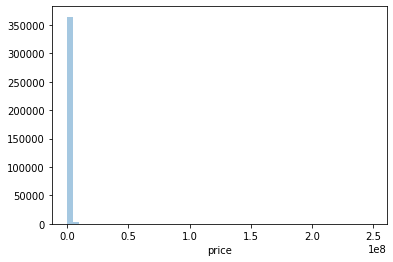

In [ ]:
sns.distplot(df[df['data_type']=='train']['price'], kde=False)

In [ ]:
left_price, right_price = outliers_detection_IQR(df[df['data_type']=='train'], 'price')

price feature
min: 11000, max: 248623920
outlier boundaries: [-713500.0, 1802500.0]
ratio of outliers: 0.08662696411040782




/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram for prices less than 3 million')

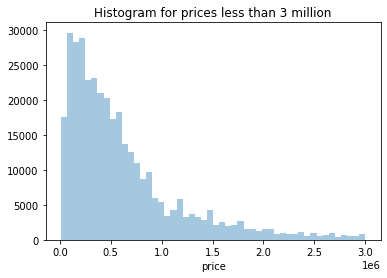

In [ ]:
sns.distplot(df[(df['data_type']=='train')&(df['price']<3000000)]['price'], kde=False)
plt.title('Histogram for prices less than 3 million')

In [ ]:
print(f"Цена больше 10млн у {round(df[df['price']>10000000].shape[0] / df.shape[0] * 100, 2)}% выборки")
print(f"Цена больше 90млн у {round(df[df['price']>90000000].shape[0] / df.shape[0] * 100, 5)}% выборки")

Цена больше 10млн у 0.13% выборки
Цена больше 90млн у 0.00074% выборки


`price` 

1. Выбросы по нижней границе
* 11K-25K: много отечественных марок; на запчасти/даром/требующие ремонта/проблемы вроде не заводится; в среднем 2.4 владельца; в среднем 1991 год (макс 2008 год)
* 25K-75K: нормальное состояние/требуется ремонт; в среднем 1997 год и 2.6 владельцев
* 75K-100K: на ходу/много замен; 1996 год 2.6 владельцев
2. Выбросы по верхней границе >25 млн
* 'Rolls-Royce', 'Mercedes-Benz', 'Ferrari', 'Porsche', 'Maybach', 'Aston Martin', 'Bentley' - большинство объявлений оф дилеров
*  'ЗиС', 'ЗИЛ', 'ГАЗ' - реставрация с ориг запчастями
3. Экстремальные значения (минимальные и максимальные) приходятся либо на отечественное старьё даром или на запчасти, либо на ретро или коллекционные автомобили - между собой их можно различить только(?) по `description` и по `brand`. Самые дорогие машины в дата сете от брендов 'Rolls-Royce', 'Mercedes-Benz', 'Ferrari', 'Porsche', 'Maybach', 'Aston Martin', 'Bentley' - всё экстра люксовые бренды. В тестовой выборке из них есть только Mercedes, скорее всего удалим из дата сета машины остальных марок.

## Подготовка данных

In [ ]:
def fill_nan(data):

    #data = data.copy()
    
    data['engineDisplacement'].fillna(1.8, inplace=True)
    data['enginePower'].fillna(125.0, inplace=True)

    data['fuelType'].fillna('Бензин', inplace=True)
    data['numberOfDoors'].fillna('-1', inplace=True)
    data['vehicleTransmission'].fillna('механическая', inplace=True)
    data['ПТС'].fillna('Оригинал', inplace=True)
    data['Привод'].fillna('передний', inplace=True)

    return data

def replace_outliers(data):
    # replace outliers based on the analysis in the notebook

    np.random.seed(RANDOM_SEED)

    data = data.copy()

    mean_eD = data.engineDisplacement[data.engineDisplacement < 6].mean()
    data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: x if x < 6 else mean_eD + round(np.random.rand(), 1))

    mean_eP = data.enginePower.mean()
    data['enginePower'] = data['enginePower'].apply(lambda x: x if x < 600 else mean_eP + round(np.random.rand(), 1) * 100)
    
    data = data[~data['brand'].isin(['Rolls-Royce', 'Ferrari', 'Porsche', 'Maybach', 'Aston Martin', 'Bentley'])]

    data['productionDate'] = data['productionDate'].apply(lambda x: x if x > 1960 else np.random.randint(1960, 1975, size=1)[0])
    
    return data


In [ ]:
df = fill_nan(df)

In [ ]:
df = replace_outliers(df)

In [ ]:
# bodyType
# we take the ten most popular body options
bodyType = df.bodyType.value_counts().head(10)

# everything that does not fall into the bodyType is moved to the category 'other'
df['bodyType_other'] = df.bodyType
df['bodyType_other'] = df['bodyType_other'].apply(lambda x: x if x in bodyType else 'другой')


# color
# combine golden, purple, violet, orange, yellow and pink
color = df.color.value_counts().head(10)
df['color_other'] = df.color
df['color_other'] = df['color_other'].apply(lambda x: x if x in color else 'другой')


# fuelType
# bring to the same form and combine
df['fuelType'] = df['fuelType'].str.capitalize() 
df['fuelType_other'] = df['fuelType'].replace(['Бензин, газобаллонное оборудование', 'Гибрид', 'Газ', 'Электро', 'Газ, газобаллонное оборудование', 'Дизель, газобаллонное оборудование', 'Гибрид, газобаллонное оборудование'], 'Другое')

# убрать наны предварительно
# numberOfDoors
df['numberOfDoors'].fillna('-1', inplace=True)
df['numberOfDoors'] = df['numberOfDoors'].astype('int')


# vehicleTransmission_two
df['vehicleTransmission_two'] = df['vehicleTransmission'].replace(['вариатор', 'роботизированная'], 'автоматическая')

# brand
# collected all the options, of which there are more than 1000, the rest are combined
brand = df.brand.value_counts().head(53)
df['top_53_auto_and_other'] = df.brand
df['top_53_auto_and_other'] = df['top_53_auto_and_other'].apply(lambda x: x if x in brand else 'other')

In [ ]:
df['sell_id'] = df['sell_id'].apply(lambda x: None if x == 'n/a' else x)
df['sell_id'].fillna(-1.0, inplace=True)

df['Таможня'] = df['sell_id'].apply(lambda x: 1 if x == 'Растаможен' else x)

## Feature engineering

`brand` -> `vendor`

In [ ]:
# add more details to 'vendor', prepare 'brand' for processing
df['brand'] = df['brand'].str.upper() 
df['brand'] = df['brand'].replace(['MERCEDES'],['MERCEDES-BENZ'])

In [ ]:
def fill_vendor(row):
    if row['brand'] in ['AUDI', 'BMW', 'MERCEDES-BENZ',
                        'OPEL', 'PEUGEOT', 'PORSCHE',
                        'RENAULT', 'VOLKSWAGEN', 'VOLVO',
                        'JAGUAR', 'LAND ROVER', 'SAAB',
                        'SKODA', 'CITROEN', 'FIAT', 'MINI']:
        row['vendor'] = 'EUROPEAN'
    elif row['brand'] in ['CHERY', 'LIFAN', 'GEELY', 'GREAT WALL']:
        row['vendor'] = 'CHINESE'
    elif row['brand'] in ['CHEVROLET', 'FORD', 'DODGE', 'CHRYSLER',
                            'CADILLAC', 'JEEP', 'VORTEX']:
        row['vendor'] = 'AMERICAN'
    elif row['brand'] in ['HYUNDAI', 'SSANGYONG',
                            'DAEWOO', 'KIA']:
        row['vendor'] = 'KOREAN'
    elif row['brand'] in ['УАЗ', 'ГАЗ','LADA (ВАЗ)',
                            'ИЖ', 'ЗАЗ', 'МОСКВИЧ']:
        row['vendor'] = 'RUSSIAN'
    elif row['brand'] in ['MAZDA', 'MITSUBISHI', 'NISSAN',
                            'SUZUKI', 'TOYOTA', 'SUBARU', 'DAIHATSU',
                            'HONDA', 'INFINITI', 'LEXUS', 'DATSUN']:
        row['vendor'] = 'JAPANESE'
    return row   

In [ ]:
# Applying the function
df = df.apply(fill_vendor, axis=1)

In [ ]:
# то, что осталось с заглушкой - можно потом доделать
df[df['vendor'] == 'to be mapped'].brand.value_counts().head(30)

ЛУАЗ           624
RAVON          564
ROVER          492
ТАГАЗ          445
SEAT           440
LINCOLN        415
FAW            348
HUMMER         338
SMART          302
ISUZU          295
BYD            278
HAVAL          277
ACURA          268
ALFA ROMEO     254
PONTIAC        216
TESLA          198
HAIMA          190
BRILLIANCE     162
MASERATI       157
IRAN KHODRO    152
GENESIS        150
CHANGAN        148
ZOTYE          144
DONGFENG       106
GMC            101
HAFEI           93
BUICK           83
DACIA           80
SATURN          78
JAC             74
Name: brand, dtype: int64

`color` -> `popular_color`

In [ ]:
# add a flag if the color of the car is popular
popular_color = ['зелёный', 'чёрный', 'голубой', 'красный', 'серебристый', 'белый', 'серый', 'синий', 'коричневый']
df['popular_color'] = df['color'].apply(lambda x: 1 if x in popular_color else 0)

`description` -> `owner`, `showroom`

In [ ]:
# type of seller
df['description'] = df['description'].map(lambda x: str(x).lower())

In [ ]:
df['owner'] = df['description'].apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<200 else 0)
df['showroom'] = df['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                             or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                             or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(df['owner'].value_counts())
display(df['showroom'].value_counts())

1    311119
0     89111
Name: owner, dtype: int64

0    347647
1     52583
Name: showroom, dtype: int64

Частных продавцов больше, чем магазинов

`fuelType` -> `fuelType_gas`

In [ ]:
df['fuelType'] = df['fuelType'].str.capitalize() 
df['fuelType_gas'] = df['fuelType'].replace(['Бензин, газобаллонное оборудование','Дизель, газобаллонное оборудование', 'Газ, газобаллонное оборудование', 'Гибрид, газобаллонное оборудование'],['Бензин','Дизель', 'Газ', 'Гибрид'])


In [ ]:
df['allroad'] = df['Привод'].apply(lambda x: 1 if x == 'полный' else 0)

`brand` -> `luxury`

In [ ]:
luxury_list = [
    "AUDI",
    "BMW",
    "MERCEDES-BENZ",
    "PORSCHE",
    "JAGUAR",
    "LAND ROVER",
    "CHRYSLER",
    "CADILLAC",
    "INFINITI",
    "LEXUS",
]


In [ ]:
df['luxury'] = df['brand'].apply(lambda x: 1 if x in luxury_list else 0)

`productionDate`, `mileage`  -> `km_pro_year`

In [ ]:
df['km_pro_year'] = (df['mileage']/(2021 - df['productionDate']))
df['km_pro_year'] = round(df['km_pro_year']).replace(np.inf, 0)

In [ ]:
# defining functions to fetch currency rates from external API
def eur_rate(date):
    return currency_rate(date, 'EUR')

def usd_rate(date):
    return currency_rate(date, 'USD')

def currency_rate(date, base_currency):

    # Return from cache for repeated dates
    currency_cache = currency_rates_cache.get(base_currency)
    if date in currency_cache:
        return currency_cache.get(date)

    # Fetch API
    print('Fetching API')
    url = f'https://api.exchangeratesapi.io/{date}?base={base_currency}&symbols=RUB'
    rate = requests.get(url).json().get('rates').get('RUB')
    currency_cache[date] = rate
    return rate

`parsing_unixtime` -> `rub_usd_ratio`

In [ ]:
# Parsing date
df['parsing_date'] = df['parsing_unixtime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

# Currency rates at the moment of Ad parsing
df['rub_usd_ratio'] = df['parsing_date'].apply(usd_rate)
df['rub_eur_ratio'] = df['parsing_date'].apply(eur_rate)

Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API
Fetching API


`brand` -> `brand_rating_score`

In [ ]:
# Data source is https://www.drom.ru/topcars/firms/
brands = pd.read_json(data_directory + '/brands.json')

# brand rating number - the smaller the better [1-70]
df['brand_rating'] = df['brand'].apply(lambda brand: brands.get(brand).rating if brand in brands else None)
df['brand_rating'].fillna(df['brand_rating'].max() + 10, inplace=True)

# brand rating score - the bigger the better [9.2-6.1]
df['brand_rating_score'] = df['brand'].apply(lambda brand: brands.get(brand).rating_score if brand in brands else None)
df['brand_rating_score'].fillna(df['brand_rating_score'].min() - 1, inplace=True)


## Корреляционная матрица

In [ ]:
# define numerical features
num_f = ['engineDisplacement', 'enginePower', 'mileage', 'parsing_unixtime', 
         'numberOfDoors', 'productionDate','sell_id', 'Владельцы', 'Таможня', 
         'popular_color', 'owner', 'showroom', 'allroad', 'luxury', 'km_pro_year',
         'rub_usd_ratio', 'rub_eur_ratio', 'brand_rating',
       'brand_rating_score']

target = 'price'

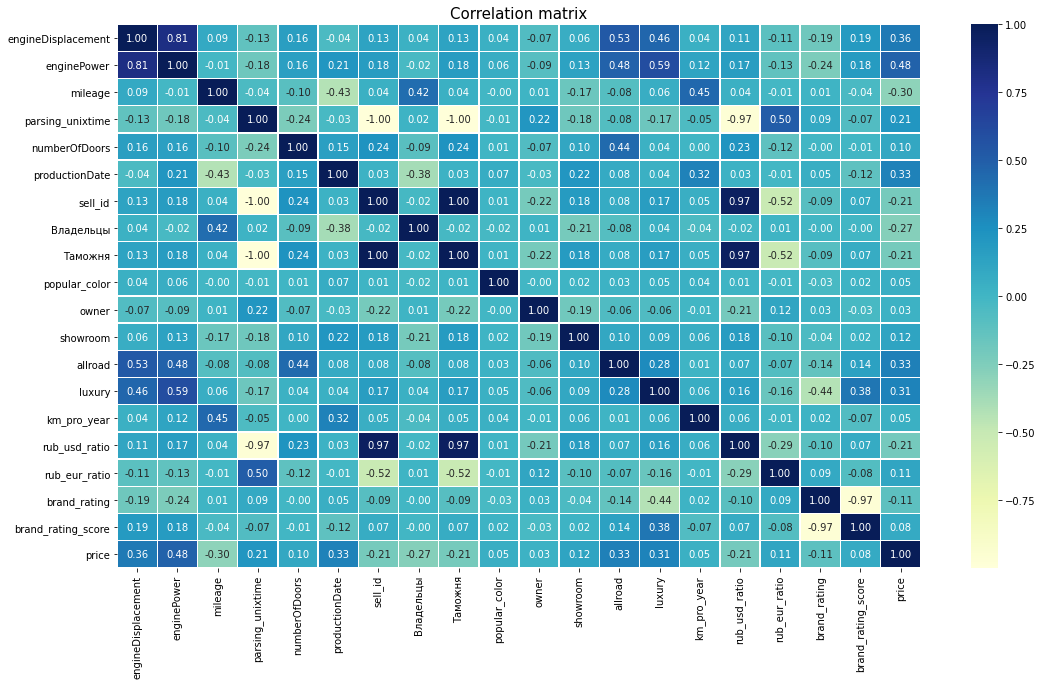

In [ ]:
# checking the correlation between all variables
plt.figure(figsize=(18, 10))
sns.heatmap(train[num_f + [target]].corr(), annot=True,
            fmt='.2f', cmap='YlGnBu', linewidth=0.5)
plt.title('Correlation matrix', size=15);

Видим высокую корреляцию между:
- *engineDisplacement и enginePower* - оставить один из них или сделать на их основании новый признак
- sell_id и *parsing_unixtime* - попробовать убрать parsing_unixtime
- Таможня и parsing_unixtime - убрать Таможня
- rub_usd_ratio и parsing_unixtime
- rub_usd_ratio и sell_id 
- rub_usd_ratio и Таможня
- Таможня и sell_id
- km_pro_year и parsing_unixtime
- Таможня и rub_usd_ratio
- brand_rating и brand_rating_score - чем отличаются?

Попробовать убрать rub_usd_ratio, оставить rub_eur_ratio - оно менее взаимосвязано с другими признаками.

Попробовать привести 'bodyType', 'brand', 'color', 'fuelType' к числам и еще раз посчитать матрицу корреялции.

## Как последний шаг предобработки данных - сохраняем результаты в файл

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400230 entries, 0 to 34685
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   bodyType                 400230 non-null  object 
 1   brand                    400230 non-null  object 
 2   color                    400230 non-null  object 
 3   description              400230 non-null  object 
 4   engineDisplacement       400230 non-null  float64
 5   enginePower              400230 non-null  float64
 6   fuelType                 400230 non-null  object 
 7   mileage                  400230 non-null  int64  
 8   name                     400230 non-null  object 
 9   numberOfDoors            400230 non-null  int64  
 10  parsing_unixtime         400230 non-null  int64  
 11  price                    400230 non-null  int64  
 12  priceCurrency            400230 non-null  object 
 13  productionDate           400230 non-null  int64  
 14  sell_

In [ ]:
drop_immediately = ['description', 'name', 'priceCurrency', 'Владение', 'Состояние', 'Таможня']
df.drop(drop_immediately, axis=1, inplace=True)

df.to_csv(data_directory + '/preprocessed/auto-v1.1.сsv', index=False)

# Модели

## Общая функция для подготовки данных

In [ ]:
# Reading preprocessed data frame
preprocessed_df = train = pd.read_parquet(data_directory + '/preprocessed/auto-v1.parquet')

In [ ]:
# Naive approach - every model will have different requirements to columns set and types 

# Every model may define (pre/post)-processing steps by extending this class to fine-tune data set
class BaseModelWrapper:

    def __init__(self, df, model, selected_columns):
        self.data = df.copy()
        self.model = model
        self.selected_columns = selected_columns

    # Conversion, adding new features, dropping columns, dropping NA, dropping anomalies.
    def preprocess_X(self, train):
        return train

    # Conversion, adding new features, dropping columns. Dropping rows is forbidden.
    def preprocess_X_submission(self, test):
        return test

    # Normalizing target feature (e.g. log())
    def preprocess_y(self, y, X):
        return y

    # Denormalizing target feature (e.g. exp())
    def postprocess_y_prediction(self, prediction, X):
        return prediction

    def train(self):

        # Preprocessing train X
        train_df = self.get_train_df(self.data)
        preprocessed_data = self.preprocess_X(train_df)
        selected_data = preprocessed_data[self.selected_columns]

        # Split into train test
        X = selected_data##.drop(['price'], axis=1)
        y = preprocessed_data['price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)
        X_train_full, X_test_full, _, _ = train_test_split(preprocessed_data, y, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)

        # Training
        self.model.fit(X_train, self.preprocess_y(y_train, X_train_full))

        # Error evaluation
        y_pred = self.model.predict(X_test)
        y_pred = self.postprocess_y_prediction(y_pred, X_test_full)
        print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

        return self.model

    def submit(self, model_name=''):

        # Preprocessing
        test_df = self.get_test_df(self.data)
        X_submission = self.preprocess_X_submission(test_df)
        # X_submission = X_submission.drop(['price'], axis=1)

        # Prediction and Postprocessing
        prediction = self.model.predict(X_submission)
        prediction = self.postprocess_y_prediction(prediction, test_df)

        # Submission
        sample_submission['price'] = prediction
        sample_submission.to_csv(f'submission_{model_name}_v{VERSION}.csv', index=False)

    def get_train_df(self, data):
        return data[data['data_type'] == 'train']

    def get_test_df(self, data):
        return data[data['data_type'] == 'test']



## Наивная модель

Выбор основных численных свойств:
- engineDisplacement
- enginePower
- mileage
- productionDate (TODO: new feature - age = unix_time - productionDate )


Пример описания преобразований данных и оценка модели в строчку

In [ ]:
class NaiveModelWrapper(BaseModelWrapper):

    def __init__(self, df, model, selected_columns=['engineDisplacement', 'enginePower', 'mileage', 'productionDate']):
        super().__init__(df, model, selected_columns)

    # Conversion, adding new features, dropping columns, dropping NA, dropping anomalies.
    def preprocess_X(self, df):

        # just 2 records if not handled before
        df = df.dropna(subset=['engineDisplacement', 'enginePower'], axis=0)

        return df

    # Conversion, adding new features, dropping columns. Dropping rows is forbidden.
    def preprocess_X_submission(self, X):
        X = X[self.selected_columns]
        values = {'engineDisplacement': X['engineDisplacement'].median(), 'enginePower': X['enginePower'].median()}
        X = X.fillna(value=values)
        return X

    # Normalizing target feature (e.g. log())
    def preprocess_y(self, y, X):
        # return y / X['rub_usd_ratio']
        return np.log(y)

    # Denormalizing target feature (e.g. exp())
    def postprocess_y_prediction(self, prediction, X):
        # return prediction * X['rub_usd_ratio']
        return np.exp(prediction)

In [ ]:
# Selecting model
naive_model = NaiveModelWrapper(preprocessed_df, LinearRegression())

# Training model and scoring
naive_model.train()
# Local score - 56.70
# Kaggle score - 46.79

# Submitting model
naive_model.submit('01.LinearRegression')

Точность модели по метрике MAPE: 56.70%


## Lazy Predict

Попробовали с помощью Lazy Predict построить базовые модели, чтобы понять какие модели на нашей выборке будут работать лучше. 
Датасет, по которому делали предсказания, ограничили до рандомных 40K.

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
# Data sets for training and internal testing
# drop all object columns
X = df[df["data_type"] == "train"].drop(
    ['bodyType', 'brand', 'color', 'description', 'name', 'price', 'priceCurrency',
       'sell_id', 'vehicleTransmission', 'vendor', 'Владение',
       'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'data_type',
       'bodyType_other', 'color_other', 'fuelType_other',
       'vehicleTransmission_two', 'top_53_auto_and_other', 'fuelType_gas', 'allroad', 'luxury', 'km_pro_year',
       'rub_usd_ratio', 'rub_eur_ratio', 'brand_rating',
       'brand_rating_score'], axis=1
)
y = df[df["data_type"] == "train"]["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)


In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

| Model                         | Adjusted R-Sq.     | R-Squared  | RMSE         | Time Taken |
|-------------------------------|--------------------|------------|--------------|------------|
| XGBRegressor                  | 0.81               | 0.81       | 434658.55    | 0.42       |
| HistGradientBoostingRegressor | 0.81               | 0.81       | 436790.87    | 2.10       |
| LGBMRegressor                 | 0.81               | 0.81       | 436936.26    | 0.12       |
| RandomForestRegressor         | 0.80               | 0.80       | 447692.39    | 3.18       |
| BaggingRegressor              | 0.79               | 0.79       | 455746.50    | 0.38       |
| GradientBoostingRegressor     | 0.79               | 0.79       | 460854.83    | 0.81       |
| ExtraTreesRegressor           | 0.78               | 0.78       | 462960.01    | 2.55       |
| KNeighborsRegressor           | 0.71               | 0.71       | 534739.64    | 0.21       |
| ExtraTreeRegressor            | 0.67               | 0.67       | 573876.95    | 0.05       |
| DecisionTreeRegressor         | 0.64               | 0.64       | 596012.04    | 0.12       |
| PoissonRegressor              | 0.55               | 0.55       | 666215.76    | 0.05       |
| LinearRegression              | 0.51               | 0.51       | 699348.39    | 0.02       |
| LassoLarsIC                   | 0.51               | 0.51       | 699348.39    | 0.02       |
| TransformedTargetRegressor    | 0.51               | 0.51       | 699348.39    | 0.02       |
| LassoLarsCV                   | 0.51               | 0.51       | 699348.39    | 0.05       |
| Lars                          | 0.51               | 0.51       | 699348.39    | 0.02       |
| LarsCV                        | 0.51               | 0.51       | 699348.39    | 0.04       |
| Lasso                         | 0.51               | 0.51       | 699348.68    | 0.12       |
| Ridge                         | 0.51               | 0.51       | 699351.65    | 0.01       |
| RidgeCV                       | 0.51               | 0.51       | 699381.06    | 0.02       |
| LassoLars                     | 0.51               | 0.51       | 699384.51    | 0.02       |
| BayesianRidge                 | 0.51               | 0.51       | 699391.72    | 0.04       |
| LassoCV                       | 0.51               | 0.51       | 699532.32    | 0.21       |
| OrthogonalMatchingPursuitCV   | 0.50               | 0.50       | 703946.32    | 0.03       |
| SGDRegressor                  | 0.50               | 0.50       | 704041.44    | 0.03       |
| ElasticNet                    | 0.47               | 0.47       | 726554.97    | 0.06       |
| GammaRegressor                | 0.46               | 0.46       | 729175.10    | 0.02       |
| HuberRegressor                | 0.44               | 0.44       | 745687.19    | 0.08       |
| PassiveAggressiveRegressor    | 0.43               | 0.43       | 752892.23    | 0.97       |
| GeneralizedLinearRegressor    | 0.43               | 0.43       | 753854.68    | 0.03       |
| TweedieRegressor              | 0.43               | 0.43       | 753854.68    | 0.04       |
| OrthogonalMatchingPursuit     | 0.36               | 0.36       | 794094.12    | 0.01       |
| AdaBoostRegressor             | 0.30               | 0.30       | 832648.70    | 0.38       |
| RANSACRegressor               | 0.27               | 0.27       | 852145.46    | 0.08       |
| ElasticNetCV                  | -0.00              | 0.00       | 994731.32    | 0.22       |
| DummyRegressor                | -0.00              | -0.00      | 996442.27    | 0.03       |
| NuSVR                         | -0.05              | -0.05      | 1019794.41   | 8.22       |
| KernelRidge                   | -0.06              | -0.05      | 1021681.20   | 13.87      |
| SVR                           | -0.10              | -0.09      | 1041079.84   | 7.85       |
| MLPRegressor                  | -0.40              | -0.40      | 1177804.83   | 7.99       |
| LinearSVR                     | -0.56              | -0.56      | 1243571.74   | 0.02       |
| GaussianProcessRegressor      | -70755.09          | -70522.66  | 264539447.11 | 30.63      |

Видим, что минимальная среднеквадратичная ошибка у XGBRegressor, HistGradientBoostingRegressor, LGBMRegressor.

## Stacking

Берем топ алгоритмы из прогона `LazyRegressor` и используем их в первом слое Стакинга. Используем только числовые свойства как подходящие большинству алгоритмов. Предварительно делаем оценку качества по нашей метрике с кросс-валидацией, сравниваем с метрикой всей Stacking модели. 


In [ ]:
# Target metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Target metrics as scorer
def mape_scorer(estimator, X, y):
    prediction = estimator.predict(X)
    return mape(y, prediction)

In [ ]:
# Loading preprocessed previously data set
stacking_df = pd.read_parquet(data_directory + '/preprocessed/auto-v1.parquet')

# Due to online IDE limitation working with data random subset (for demo purposes only)
stacking_df = stacking_df.sample(n=1000, random_state=42, axis=0)

In [ ]:
# Using number features only (as compatible with every algorithm selected)
def get_dataset():
    selected_columns=['engineDisplacement', 'enginePower', 'mileage', 'numberOfDoors', 'parsing_unixtime', 'productionDate', 'popular_color', 'owner', 'showroom', 'brand_rating', 'brand_rating_score']
    X = stacking_df[selected_columns]
    y = stacking_df['price']

    return X, y

# Stacking ensemble of models
def get_stacking():

	# define base models
    level0 = list()
    level0.append(('LGBM', LGBMRegressor()))
    level0.append(('ExtraTrees', ExtraTreesRegressor()))
    level0.append(('XGB', XGBRegressor()))
    level0.append(('GradientBoosting', GradientBoostingRegressor()))
    level0.append(('RandomForest', RandomForestRegressor()))
    level0.append(('KNeighbors', KNeighborsRegressor()))
    level0.append(('Bagging', BaggingRegressor()))
    level0.append(('ExtraTree', ExtraTreeRegressor()))
    level0.append(('DecisionTree', DecisionTreeRegressor()))

	# define learner model
    level1 = LinearRegression()

	# define stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)
    return model

# List of models, for comparison evaluation only
def get_models():
    models = dict()
    models['LGBM'] = LGBMRegressor()
    models['ExtraTrees'] = ExtraTreesRegressor()
    models['XGB'] = XGBRegressor()
    models['GradientBoosting'] = GradientBoostingRegressor()
    models['RandomForest'] = RandomForestRegressor()
    models['KNeighbors'] = KNeighborsRegressor()
    models['Bagging'] = BaggingRegressor()
    models['ExtraTree'] = ExtraTreeRegressor()
    models['DecisionTree'] = DecisionTreeRegressor()
    models['stacking'] = get_stacking()
    return models

# Evaluate a given model using cross-validation and our metrics
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring=mape_scorer, cv=cv, n_jobs=-1, error_score='raise')
	return scores

>LGBM 31426.970 (20261.550)
>ExtraTrees 3126.815 (3460.238)
>XGB 13183.908 (9053.232)
>GradientBoosting 10938.100 (6395.732)
>RandomForest 11752.343 (8013.169)
>KNeighbors 1.319 (0.287)
>Bagging 11723.460 (9648.636)
>ExtraTree 3837.479 (7497.186)
>DecisionTree 2998.431 (7523.956)
>stacking 7063.113 (4454.748)


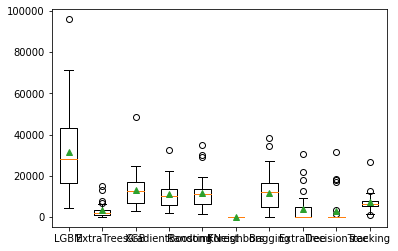

In [ ]:
# Models evaluation
X, y = get_dataset()
models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


## ExtraTreesRegressor
* Ансамблевый алгоритм 
* Работает быстрее, чем Random Forest - существенно, так как имеем большой дата сет

[Источник](https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/) с более подробным сравнением

In [ ]:
df = pd.read_csv(data_directory + '/preprocessed/auto-v1.1.сsv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400230 entries, 0 to 400229
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   bodyType                 400230 non-null  object 
 1   brand                    400230 non-null  object 
 2   color                    400230 non-null  object 
 3   engineDisplacement       400230 non-null  float64
 4   enginePower              400230 non-null  float64
 5   fuelType                 400230 non-null  object 
 6   mileage                  400230 non-null  int64  
 7   numberOfDoors            400230 non-null  int64  
 8   parsing_unixtime         400230 non-null  int64  
 9   price                    400230 non-null  int64  
 10  productionDate           400230 non-null  int64  
 11  sell_id                  400230 non-null  float64
 12  vehicleTransmission      400230 non-null  object 
 13  vendor                   400230 non-null  object 
 14  Влад

In [ ]:
def split_df(df):

    X = df[df['data_type'] == 'train'].drop(['price', 'data_type'], axis=1)
    y = df[df['data_type'] == 'train']['price']
    return train_test_split(X, y, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)

def get_X_submission(df):

    return df[df['data_type'] == 'test'].drop(['price', 'data_type'], axis=1)

def preprocess(data, columns2drop=['bodyType', 'brand', 'color', 'fuelType',
    	                        'parsing_unixtime', 'sell_id', 'vehicleTransmission_two', 'vendor'], 
                    columns2encode=['vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'bodyType_other', 
                                    'color_other', 'fuelType_other', 'top_53_auto_and_other'], 
                        columns2log=['price', 'mileage'], log=True):
    
    # dropping selected columns
    data.drop(columns2drop, axis=1, inplace=True)

    # encoding categorical columns to numerical variables
    for col in columns2encode:
        data[col], _ = pd.factorize(data[col])

    # taking logarithm of selected features
    if log: 
        for col in columns2log:
            data[col] = data[col].apply(lambda x: np.log(x))

    return data

### Первая итерация

In [ ]:
cols2select_iter1 = ['price', 'data_type', 'enginePower', 'mileage', 'numberOfDoors', 'productionDate', 'Владельцы', 'showroom', 'allroad', 'rub_usd_ratio', 'brand_rating']

X_train, X_test, y_train, y_test = split_df(df[cols2select_iter1])
X_sub = get_X_submission(df[cols2select_iter1])

et_default = ExtraTreesRegressor(random_state=RANDOM_SEED)

et_default.fit(X_train, y_train)

y_pred = et_default.predict(X_test)
print(f'MAPE: {mape(y_test, y_pred)}')

# MAPE: 0.1668866661256874
# Kaggle: 27.23341

### Вторая итерация
Используем больше признаков и делаем дамми-переменные по некоторым из них.

Новые признаки: `'bodyType_other',
 'color_other',
 'engineDisplacement',
 'fuelType_other',
 'popular_color',
 'top_53_auto_and_other',
 'vehicleTransmission',
 'ПТС',
 'Привод',
 'Руль'`

In [ ]:
X_train, X_test, y_train, y_test = split_df(preprocess(df.iloc[:, :25]))
X_sub = get_X_submission(preprocess(df.iloc[:, :25]))

ohe = OneHotEncoder()

# train set
# generating dummy variables on categorical features in X_a
X_a_train = ohe.fit_transform(X_train[['vehicleTransmission', 'ПТС', 'Привод', 
                                    'Руль', 'bodyType_other', 'color_other', 'fuelType_other']])

# all other features are in X_b
X_b_train = X_train[['engineDisplacement', 'enginePower', 'mileage',  'numberOfDoors', 'productionDate', 'Владельцы', 'top_53_auto_and_other']].values

X_train = hstack([X_a_train, X_b_train]).toarray()


# test set
# generating dummy variables on categorical features in X_a
X_a_test = ohe.fit_transform(X_test[['vehicleTransmission', 'ПТС', 'Привод', 
                                    'Руль', 'bodyType_other', 'color_other', 'fuelType_other']])

# all other features are in X_b
X_b_test = X_test[['engineDisplacement', 'enginePower', 'mileage',  'numberOfDoors', 'productionDate', 'Владельцы', 'top_53_auto_and_other']].values

X_test = hstack([X_a_test, X_b_test]).toarray()


# submission set
# generating dummy variables on categorical features in X_a
X_a_sub = ohe.fit_transform(X_sub[['vehicleTransmission', 'ПТС', 'Привод', 
                                    'Руль', 'bodyType_other', 'color_other', 'fuelType_other']])

# all other features are in X_b
X_b_sub = X_sub[['engineDisplacement', 'enginePower', 'mileage',  'numberOfDoors', 'productionDate', 'Владельцы', 'top_53_auto_and_other']].values

X_sub = hstack([X_a_sub, X_b_sub]).toarray()

In [ ]:
# model
et_default = ExtraTreesRegressor(random_state=RANDOM_SEED)

et_default.fit(X_train, y_train)

y_pred = et_default.predict(X_test)
print(f'MAPE: {mape(np.exp(y_test), np.exp(y_pred))}')

# MAPE: 0.09837627273111214
# Kaggle:  19.69915

### Третья итерация
Предобработка данных та же, что и во второй итерации.

Запустили GridSearchCV с сеткой параметров `'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 10, 100],
    'min_samples_leaf': [1, 10, 100]
    'bootstrap': [True, False]` 

Лучший результат показала модель `ExtraTreesRegressor(bootstrap=True, n_estimators=300, random_state=42)`: MAPE ~ 2.1% на кросс-валидации, что подозрительно мало, и скорее всего модель переобучилась.

In [ ]:
et_optimal = ExtraTreesRegressor(
    n_estimators=300,
    bootstrap=True,
    random_state=RANDOM_SEED
)

et_optimal.fit(X_train, y_train)

y_pred = et_optimal.predict(X_test)
print(f'MAPE: {mape(np.exp(y_test), np.exp(y_pred))}')

# MAPE: 0.12502457633890735
# Kaggle: 19.35421

### Четвёртая итерация
Немного изменили набор признаков и дамми-переменных.

In [ ]:
cols2select_iter2 = ['bodyType_other', 'brand', 'engineDisplacement', 'enginePower', 'fuelType_other', 'mileage', 'numberOfDoors', 'price', 'productionDate', 'vehicleTransmission',
                   'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'data_type', 'owner', 'showroom', 'allroad', 'km_pro_year', 'brand_rating']
cols2encode_iter2 = ['bodyType_other', 'brand', 'fuelType_other', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль']

cols2dummy_iter2 = ['bodyType_other', 'fuelType_other', 'vehicleTransmission', 'ПТС']

X_train, X_test, y_train, y_test = split_df(preprocess(df.loc[:, cols2select_iter2], columns2drop=[], columns2encode=cols2encode_iter2))
X_sub = get_X_submission(preprocess(df.loc[:, cols2select_iter2], columns2drop=[], columns2encode=cols2encode_iter2))

In [ ]:
ohe = OneHotEncoder()

# train set
# generating dummy variables on categorical features in X_a
X_a_train = ohe.fit_transform(X_train.loc[:, cols2dummy_iter2])

# all other features are in X_b
X_b_train = X_train[set(X_train.columns.values) - set(cols2dummy_iter2)].values

X_train = hstack([X_a_train, X_b_train]).toarray()


# test set
# generating dummy variables on categorical features in X_a
X_a_test = ohe.fit_transform(X_test.loc[:, cols2dummy_iter2])

# all other features are in X_b
X_b_test = X_test[set(X_test.columns.values) - set(cols2dummy_iter2)].values

X_test = hstack([X_a_test, X_b_test]).toarray()


# submission set
# generating dummy variables on categorical features in X_a
X_a_sub = ohe.fit_transform(X_sub.loc[:, cols2dummy_iter2])

# all other features are in X_b
X_b_sub = X_sub[set(X_sub.columns.values) - set(cols2dummy_iter2)].values

X_sub = hstack([X_a_sub, X_b_sub]).toarray()

In [ ]:
et_default = ExtraTreesRegressor(random_state=RANDOM_SEED)

et_default.fit(X_train, y_train)

y_pred = et_default.predict(X_test)
print(f'MAPE: {mape(np.exp(y_test), np.exp(y_pred))}')

# MAPE: 0.10154715347680353
# Kaggle: 16.84646

In [ ]:
et_optimal = ExtraTreesRegressor(
    n_estimators=300,
    bootstrap=True,
    random_state=RANDOM_SEED
)

et_optimal.fit(X_train, y_train)

y_pred = et_optimal.predict(X_test)
print(f'MAPE: {mape(np.exp(y_test), np.exp(y_pred))}')
# MAPE: 0.12502457633890735
# Kaggle: 16.42917

## AdaBoostRegressor
Данные те же. Для гридсёрча не хватает мощностей, поэтому экспериментируем с параметрами вручную.

In [ ]:
ada_boost_iter1 = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=100,
                                         random_state=RANDOM_SEED),
    n_estimators=300,
    learning_rate=0.2,
    random_state=RANDOM_SEED
)

ada_boost_iter1.fit(X_train, y_train)
y_pred = ada_boost_iter1.predict(X_test)
print(f'MAPE: {mape(np.exp(y_test), np.exp(y_pred))}')
# params: max_depth=80, learning_rate=0.8
# MAPE: 0.1261705183898318
# Kaggle: 16.33093

# params: max_depth=100, learning_rate=0.5, n_estimators=100
# MAPE: 0.1135863862030893

# params: max_depth=100, learning_rate=0.2, n_estimators=100
# MAPE: 0.10199625852325307
# Kaggle: 16.33587

# params: max_depth=100, learning_rate=0.2, n_estimators=300
# MAPE: 0.11487842417595412

Уменьшение параметра `learning_rate` положительно повлияло на метрику в тестовом сете, но результат на сабмите улучшился лишь на десятую процента.

## CatBoost

Алгоритм, который направлен на обработку категориальных данных, которых у нас большинство в датасете.

In [ ]:
df = pd.read_parquet('/work/sf_module_6/data/preprocessed/auto-v1.parquet')

In [ ]:
# Data sets for training and internal testing
X = df[df['data_type'] == 'train'].drop(['price', 'data_type', 'description', 'Состояние', 'Таможня'], axis=1)
y = df[df['data_type'] == 'train']['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)

# Data set will be used for prediction and submission (external testing)
X_submission = df[df['data_type'] == 'test']

In [ ]:
# check result
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365544 entries, 0 to 368741
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   bodyType                 365544 non-null  object
 1   brand                    365544 non-null  object
 2   color                    365544 non-null  object
 3   engineDisplacement       365544 non-null  object
 4   enginePower              365544 non-null  object
 5   fuelType                 365544 non-null  object
 6   mileage                  365544 non-null  object
 7   name                     365544 non-null  object
 8   numberOfDoors            365544 non-null  object
 9   parsing_unixtime         365544 non-null  object
 10  priceCurrency            365544 non-null  object
 11  productionDate           365544 non-null  object
 12  sell_id                  365544 non-null  object
 13  vehicleTransmission      365544 non-null  object
 14  vendor              

CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать:

In [ ]:
cat_features_ids = np.where(X.dtypes != np.float)[0]

In [ ]:
print("Количество столбцов с категориальными признаками: %2d" % (len(X_train.nunique())))

Количество столбцов с категориальными признаками: 37


In [ ]:
X_train.nunique()

bodyType                  23
brand                    161
color                     16
engineDisplacement       118
enginePower              439
fuelType                   8
mileage                40525
name                    2379
numberOfDoors              5
parsing_unixtime           1
priceCurrency              1
productionDate            92
sell_id                    1
vehicleTransmission        4
vendor                     1
Владельцы                  3
Владение                   1
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [ ]:
X_train.sample(3)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль
193406,внедорожник,Mercedes-Benz,белый,3.0,245.0,Дизель,48000,3.0 л / 245л.с. /,5,1611599960,RUB,2016,n/a,автоматическая,to be mapped,2,,Оригинал,полный,Левый
345823,внедорожник открытый,ЛуАЗ,голубой,1.2,40.0,Бензин,69000,1.2 л / 40л.с. /,-1,1611599960,RUB,1987,n/a,механическая,to be mapped,2,,Оригинал,полный,Левый
343266,внедорожник,Volvo,белый,2.4,163.0,Дизель,175500,2.4 л / 163л.с. /,5,1611599960,RUB,2011,n/a,автоматическая,to be mapped,1,,Оригинал,полный,Левый


In [ ]:
# fit model
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0398538	test: 2.0363056	best: 2.0363056 (0)	total: 1.05s	remaining: 34m 52s
100:	learn: 0.3374389	test: 0.3157863	best: 0.3157863 (100)	total: 1m 18s	remaining: 24m 34s
200:	learn: 0.3096963	test: 0.2928823	best: 0.2927277 (197)	total: 2m 42s	remaining: 24m 13s
300:	learn: 0.2945678	test: 0.2792881	best: 0.2792836 (299)	total: 4m 5s	remaining: 23m 7s
400:	learn: 0.2849954	test: 0.2704480	best: 0.2703983 (398)	total: 5m 32s	remaining: 22m 4s
500:	learn: 0.2780305	test: 0.2637307	best: 0.2637307 (500)	total: 7m 1s	remaining: 21m
600:	learn: 0.2716060	test: 0.2578897	best: 0.2578897 (600)	total: 8m 33s	remaining: 19m 54s
700:	learn: 0.2640333	test: 0.2507034	best: 0.2507034 (700)	total: 10m 7s	remaining: 18m 46s
800:	learn: 0.2589668	test: 0.2455339	best: 0.2455339 (800)	total: 11m 46s	remaining: 17m 36s
900:	learn: 0.2553515	test: 0.2423655	best: 0.2423655 (900)	total: 13m 23s	remaining: 16m 20s
1000:	learn: 0.2519877	test: 0.2393412	best: 0.2393412 (1000)	total: 15m	remainin

В первое обучение средняя ошибка составила 22.4% - датасет был без стобцов из FE, было разделение на int и object, было 2000 итераций.

Во второе обучение средняя ошибка 20.6% на 2992 итерации. В датасет добавлены признаки, все значения приведены к object, так как есть колонка, где должна остаться плавающая точка.

In [ ]:
model.save_model('catboost.model')

In [ ]:
# check the significance of the features
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

Наиболее значимые для алгоритма - productionDate, engineDisplacement, name, enginePower.
Наименее значимые - parsing_date, popular_color, allroad, showroom, Руль.

### Submission

In [ ]:
def submit_prediction(prediction, model_name=''):
    sample_submission['price'] = prediction
    sample_submission.to_csv(f'submission_{model_name}_v{VERSION}.csv', index=False)

def predict_and_submit(trained_model, model_name):
    prediction = trained_model.predict(preprocess_submission_data_set(X_submission.copy()))



# Выводы

### Что сделали?
- Собрали большой чистый дата сет, готовый для экспериментов
- Поэкспериментировали с алгоритмами: LinearRegression, ExtraTreesRegressor, CatBoost
- Получили скор на Kaggle: 16.42917 (to be improved)

### Какие возникли проблемы?
- Не хватало мощности для эскпериментов, так как данных много (>400K строк)
- Не пришли к удобному унифицированному процессу обёртки моделей


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cb2d12f9-2ba3-4e27-9bc0-706ae512c116' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>